In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from statsmodels.regression.rolling import RollingOLS

# Data

In [5]:
raw = pd.read_excel("../data/raw.xlsx")
raw.head()

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Fiscal Year-end Month,Industry Format,Level of Consolidation - Company Interim Descriptor,Population Source,Data Format,Ticker Symbol,...,Calendar Data Year and Quarter,Fiscal Data Year and Quarter,Assets - Total,Invested Capital - Total - Quarterly,Net Income (Loss),Stockholders Equity - Total,Capital Expenditures,Operating Activities - Net Cash Flow,Active/Inactive Status Marker,Standard Industry Classification Code
0,1045,1963-03-31,1963,1.0,12,INDL,C,D,STD,AAL,...,1963Q1,1963Q1,NaN,NaN,NaN,NaN,NaN,NaN,A,4512
1,1045,1963-06-30,1963,2.0,12,INDL,C,D,STD,AAL,...,1963Q2,1963Q2,NaN,NaN,NaN,NaN,NaN,NaN,A,4512
2,1045,1963-09-30,1963,3.0,12,INDL,C,D,STD,AAL,...,1963Q3,1963Q3,NaN,NaN,NaN,NaN,NaN,NaN,A,4512
3,1045,1963-12-31,1963,4.0,12,INDL,C,D,STD,AAL,...,1963Q4,1963Q4,NaN,NaN,NaN,NaN,NaN,NaN,A,4512
4,1045,1964-03-31,1964,1.0,12,INDL,C,D,STD,AAL,...,1964Q1,1964Q1,NaN,NaN,NaN,NaN,NaN,NaN,A,4512


In [6]:
raw.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Fiscal Year-end Month', 'Industry Format',
       'Level of Consolidation - Company Interim Descriptor',
       'Population Source', 'Data Format', 'Ticker Symbol', 'Company Name',
       'ISO Currency Code', 'Calendar Data Year and Quarter',
       'Fiscal Data Year and Quarter', 'Assets - Total',
       'Invested Capital - Total - Quarterly', 'Net Income (Loss)',
       'Stockholders Equity - Total', 'Capital Expenditures',
       'Operating Activities - Net Cash Flow', 'Active/Inactive Status Marker',
       'Standard Industry Classification Code'],
      dtype='object')

# functions

In [14]:
def rmv_outliner(data, method="3sigma", lo_q=0.01, hi_q=0.99, fill="delete"):
    '''
    remove outliner
    '''
    if method == "3sigma":
        _h = data.mean() + 3*data.std()
        _l = data.mean() - 3*data.std()
    elif method == "quantile":
        q = data.quantile([lo_q, hi_q])
        _l = q.iloc[0]
        _h = q.iloc[1]

    if fill == "delete":
        for colname in data.columns:
            data = data.copy()
            data = data[(data[colname] < _h[colname]) &
                        (data[colname] > _l[colname])]

    return data

# Calculation

In [37]:
# average invested capital
raw["pre_IC"] = raw["Invested Capital - Total - Quarterly"].shift()
raw["ave_IC"] = (
    raw["Invested Capital - Total - Quarterly"] + raw["pre_IC"]) * 1/2

# for companies which do not have Capital Expenditures: nan --> 0
raw[raw['Capital Expenditures'] == np.nan] = 0
raw["FCF"] = raw['Operating Activities - Net Cash Flow'] - \
    raw['Capital Expenditures']

raw["FCFROIC"] = raw["FCF"]/raw["ave_IC"]

# for those finance service companies
raw["ave_equity"] = (raw["Stockholders Equity - Total"] +
                     raw["Stockholders Equity - Total"].shift()) * 1/2
raw["ave_asset"] = (raw['Assets - Total'] +
                    raw['Assets - Total'].shift()) * 1/2

raw["NI_chg"] = raw["Net Income (Loss)"].diff().copy()
raw[raw["Fiscal Quarter"] == 1]["NI_chg"] = raw[raw["Fiscal Quarter"]
                                                == 1]["Net Income (Loss)"]

#####################################
raw["NI_chg"] = raw["NI_chg"]
raw["ROA"] = raw["NI_chg"]/raw["ave_asset"]
raw["ROE"] = raw["NI_chg"]/raw["ave_equity"]

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [38]:
raw

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Fiscal Year-end Month,Industry Format,Level of Consolidation - Company Interim Descriptor,Population Source,Data Format,Ticker Symbol,...,ave_IC,FCF,FCFROIC,ave_equity,ave_asset,NI_chg,ROA,ROE,SIC,FCFROIC_ADJ
0,1045,1963-03-31 00:00:00,1963,1.0,12,INDL,C,D,STD,AAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4512,NaN
1,1045,1963-06-30 00:00:00,1963,2.0,12,INDL,C,D,STD,AAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4512,NaN
2,1045,1963-09-30 00:00:00,1963,3.0,12,INDL,C,D,STD,AAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4512,NaN
3,1045,1963-12-31 00:00:00,1963,4.0,12,INDL,C,D,STD,AAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4512,NaN
4,1045,1964-03-31 00:00:00,1964,1.0,12,INDL,C,D,STD,AAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4512,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184254,328795,2021-06-30 00:00:00,2021,2.0,12,INDL,C,D,STD,ACA,...,2380.15,9.6,0.004033,1915.90,2878.10,4.9,0.001703,0.002558,3440,0.004033
184255,328795,2021-09-30 00:00:00,2021,3.0,12,INDL,C,D,STD,ACA,...,2642.75,16.0,0.006054,1930.70,3195.70,2.9,0.000907,0.001502,3440,0.006054
184256,328795,2021-12-31 00:00:00,2021,4.0,12,INDL,C,D,STD,ACA,...,2669.65,81.4,0.030491,1947.10,3244.65,-14.5,-0.004469,-0.007447,3440,0.030491
184257,328795,2022-03-31 00:00:00,2022,1.0,12,INDL,C,D,STD,ACA,...,2650.15,-1.4,-0.000528,1965.45,3222.45,11.0,0.003414,0.005597,3440,-0.000528


In [43]:
# finance industry: SIC code 6000-6411
raw['SIC'] = raw['Standard Industry Classification Code'].astype(int)
raw["FCFROIC_ADJ"] = raw["FCFROIC"].copy()
raw.loc[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "FCFROIC_ADJ"] = raw.loc[(
    raw['SIC'] >= 6000) & (raw["SIC"] <= 6411), "ROE"]

In [30]:
raw[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411)].loc[:, "FCFROIC_ADJ"] = raw[(
    raw['SIC'] >= 6000) & (raw["SIC"] <= 6411)].loc[:, "ROE"]


/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [39]:
raw.loc[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411)]


,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Fiscal Year-end Month,Industry Format,Level of Consolidation - Company Interim Descriptor,Population Source,Data Format,Ticker Symbol,...,ave_IC,FCF,FCFROIC,ave_equity,ave_asset,NI_chg,ROA,ROE,SIC,FCFROIC_ADJ
967,1177,1971-03-31 00:00:00,1971,1.0,12,INDL,C,D,STD,AET,...,5853.9085,NaN,NaN,NaN,NaN,-232.188,NaN,NaN,6324,NaN
968,1177,1971-06-30 00:00:00,1971,2.0,12,INDL,C,D,STD,AET,...,1382.4450,NaN,NaN,NaN,NaN,10.313,NaN,NaN,6324,NaN
969,1177,1971-09-30 00:00:00,1971,3.0,12,INDL,C,D,STD,AET,...,1409.3290,NaN,NaN,NaN,NaN,9.221,NaN,NaN,6324,NaN
970,1177,1971-12-31 00:00:00,1971,4.0,12,INDL,C,D,STD,AET,...,1420.5095,NaN,NaN,NaN,NaN,-4.137,NaN,NaN,6324,NaN
971,1177,1972-03-31 00:00:00,1972,1.0,12,INDL,C,D,STD,AET,...,1458.1715,NaN,NaN,NaN,NaN,-10.451,NaN,NaN,6324,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184201,318728,2021-06-30 00:00:00,2021,2.0,12,INDL,C,D,STD,ATH,...,22824.5000,2498.0,0.109444,20003.5,210609.5,803.000,0.003813,0.040143,6311,0.109444
184202,318728,2021-09-30 00:00:00,2021,3.0,12,INDL,C,D,STD,ATH,...,25088.0000,7261.0,0.289421,22021.5,219972.5,-684.000,-0.003109,-0.031061,6311,0.289421
184203,318728,2021-12-31 00:00:00,2021,4.0,12,INDL,C,D,STD,ATH,...,25591.0000,10292.0,0.402173,22276.5,229772.5,362.000,0.001575,0.016250,6311,0.402173
184204,318728,2022-03-31 00:00:00,2022,1.0,12,INDL,C,D,STD,ATH,...,25061.0000,155.0,0.006185,17936.5,240641.5,-2578.000,-0.010713,-0.143729,6311,0.006185


In [44]:
raw[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411)]["FCFROIC_ADJ"]

967            NaN
968            NaN
969            NaN
970            NaN
971            NaN
            ...   
184201    0.040143
184202   -0.031061
184203    0.016250
184204   -0.143729
184205   -0.074586
Name: FCFROIC_ADJ, Length: 25192, dtype: float64

In [45]:
raw[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411)]["FCFROIC"]

967            NaN
968            NaN
969            NaN
970            NaN
971            NaN
            ...   
184201    0.109444
184202    0.289421
184203    0.402173
184204    0.006185
184205    0.284049
Name: FCFROIC, Length: 25192, dtype: float64

In [16]:
raw.shape

(184259, 33)

In [17]:
raw[["Global Company Key", "Data Date",
      "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC",
      "ROA", "ROE", "FCFROIC", "FCFROIC_ADJ"]].describe()


,Global Company Key,Fiscal Year,Fiscal Quarter,FCFROIC,ROA,ROE,FCFROIC,FCFROIC_ADJ
count,184259.000000,184259.000000,184237.000000,131662.000000,161214.000000,8.256700e+04,131662.000000,131662.000000
mean,36422.917339,2000.991935,2.486737,0.043755,0.000943,-inf,0.043755,0.043755
std,52551.800257,14.604700,1.115949,5.608762,0.573144,NaN,5.608762,5.608762
min,1045.000000,1961.000000,1.000000,-558.000000,-158.350877,-inf,-558.000000,-558.000000
25%,6268.000000,1992.000000,1.000000,-0.011898,-0.004177,-1.200550e-02,-0.011898,-0.011898
50%,11649.000000,2003.000000,2.000000,0.027661,0.000338,1.048255e-03,0.027661,0.027661
75%,30490.000000,2013.000000,3.000000,0.077103,0.005299,1.392418e-02,0.077103,0.077103
max,328795.000000,2023.000000,4.000000,1943.333333,142.758621,1.183661e+02,1943.333333,1943.333333


In [47]:
grouped = raw.groupby('Global Company Key')
FCFROIC_ADJ = pd.DataFrame(columns=["Global Company Key", "Data Date",
                                    "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC",
                                    "ROA", "ROE", "FCFROIC_", "FCFROIC_ADJ", "avg_fcfroic"])
for group in grouped:
    group = group[1].iloc[1:][["Global Company Key", "Data Date",
                               "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC",
                               "ROA", "ROE", "FCFROIC_ADJ"]].copy()
    # clean = rmv_outliner(group[["FCFROIC"]])
    # remove outliners
    # clean.columns = ["filtered"]
    # group = group.merge(clean, left_index=True, right_index=True, how="left")
    # 10y average
    group["avg_fcfroic1"] = group[["FCFROIC"]].rolling(
        40).mean().fillna(method="ffill")
    group["avg_fcfroic_expanding1"] = group[["FCFROIC"]].expanding(
        40).mean().fillna(method="ffill")
    group["avg_fcfroic"] = group[["FCFROIC_ADJ"]].rolling(40).mean().fillna(method="ffill")
    group["avg_fcfroic_expanding"] = group[["FCFROIC_ADJ"]].expanding(
        40).mean().fillna(method="ffill")
    FCFROIC_ADJ = FCFROIC_ADJ.append(group, ignore_index=True)

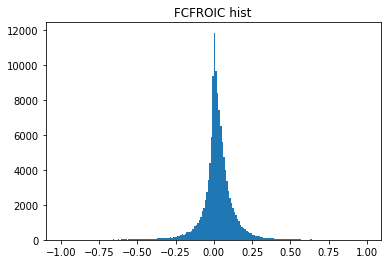

In [48]:
num = FCFROIC_ADJ["FCFROIC_ADJ"]
plt.hist(num, bins=np.arange(-1, 1, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/FCFROIC hist.png")
plt.show()

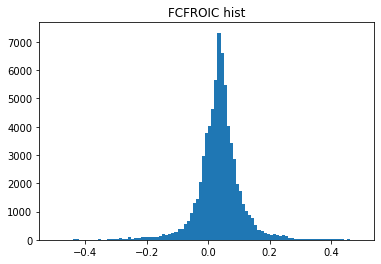

In [22]:
num = FCFROIC_ADJ["avg_fcfroic"]
plt.hist(num, bins=np.arange(-0.5, 0.5, 0.01))
plt.title("FCFROIC hist")
plt.savefig("../plot/10y average FCFROIC hist.png")
plt.show()


In [2]:
FCFROIC_ADJ[["FCFROIC_ADJ", "avg_fcfroic"]].describe()

NameError: name 'FCFROIC_ADJ' is not defined

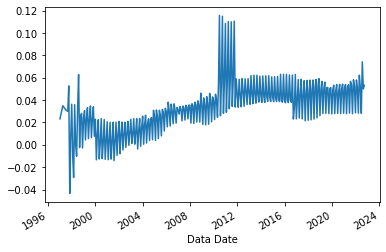

In [18]:
his_mean = FCFROIC_ADJ.groupby("Data Date").mean()
his_mean["avg_fcfroic"].dropna().plot()

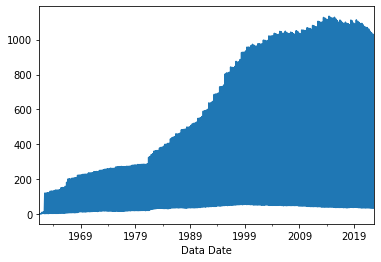

In [19]:
his_num = FCFROIC_ADJ.groupby("Data Date").count()
his_num["Global Company Key"].dropna().plot()

In [50]:
FCFROIC_ADJ.to_excel("../clean_data/FCFROIC_ADJ_1118.xlsx")

In [49]:
FCFROIC_ADJ

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_,FCFROIC_ADJ,avg_fcfroic,avg_fcfroic1,avg_fcfroic_expanding
0,1045,1963-06-30 00:00:00,1963,2.0,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1045,1963-09-30 00:00:00,1963,3.0,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1045,1963-12-31 00:00:00,1963,4.0,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1045,1964-03-31 00:00:00,1964,1.0,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1045,1964-06-30 00:00:00,1964,2.0,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182593,328795,2021-06-30 00:00:00,2021,2.0,ACA,0.004033,0.001703,0.002558,NaN,0.004033,NaN,NaN,NaN
182594,328795,2021-09-30 00:00:00,2021,3.0,ACA,0.006054,0.000907,0.001502,NaN,0.006054,NaN,NaN,NaN
182595,328795,2021-12-31 00:00:00,2021,4.0,ACA,0.030491,-0.004469,-0.007447,NaN,0.030491,NaN,NaN,NaN
182596,328795,2022-03-31 00:00:00,2022,1.0,ACA,-0.000528,0.003414,0.005597,NaN,-0.000528,NaN,NaN,NaN
